In [1]:
# # uncomment in order to download 
# !aws s3 sync s3://openproblems-bio/public/phase2-private-data/match_modality/ ./datasets/ --no-sign-request

In [2]:
!nvidia-smi

Wed Mar 15 22:05:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0    54W / 300W |   1742MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
DEVICE='cuda'

In [4]:
fold_number=0 #which group is to use as a valid fold
train_from_scratch = False #use already obtained model for postproc or get the new one

In [5]:
import numpy as np
import anndata as ad
import torch
import neptune
import pandas as pd
import shutil
import pickle
import optuna
import matplotlib.pyplot as plt
import torch.nn.functional as F



from datetime import datetime
from torch import nn
from sklearn.model_selection import LeaveOneGroupOut
from tqdm.notebook import tqdm

from src.data import get_dataloaders, ModalityMatchingDataset
from src.models import Modality_CLIP, Encoder, symmetric_npair_loss
from src.catalyst_tools import scRNARunner, CustomMetric

In [6]:
first_modality = 'ADT'
assert first_modality in ['ADT', 'ATAC']
#second modality is GEX anyway
if first_modality == 'ATAC':
    import src.config_ATAC2GEX as config
else:
    import src.config_ADT2GEX as config

In [7]:
from src.preprocessing import lsiTransformer

In [8]:
from catalyst import dl, utils
import catalyst

In [9]:
current_time = datetime.now().strftime("%b%d_%H_%M_%S")

In [10]:
dump_folder = os.path.join(config.MODEL_DUMPS_STORAGE, f'{first_modality}2GEX', current_time)
logger_folder = os.path.join(config.TENSORBOARD_DUMPS_STORAGE, f'{first_modality}2GEX', current_time)
os.makedirs(dump_folder)
shutil.copy2(config.__file__, dump_folder)

'/storage1/nerusskikh/OML/dumps/ADT2GEX/Mar15_22_05_07/config_ADT2GEX.py'

In [11]:
adata_first = ad.read_h5ad(config.PATH_FIRST_TRAIN)
adata_gex = ad.read_h5ad(config.PATH_GEX_TRAIN)
sol_train = ad.read_h5ad(config.PATH_TARGET_TRAIN)
adata_gex = adata_gex[sol_train.to_df().values.argmax(1)]

In [12]:
adata_first_test = ad.read_h5ad(config.PATH_FIRST_TEST)
adata_gex_test = ad.read_h5ad(config.PATH_GEX_TEST)
sol_test = ad.read_h5ad(config.PATH_TARGET_TEST)
adata_gex_test = adata_gex_test[sol_test.to_df().values.argmax(1)]

In [13]:
logo = LeaveOneGroupOut()
groups = sol_train.obs.batch
logo.get_n_splits(adata_gex, groups=groups)

9

In [14]:
train_index, val_index = list(logo.split(adata_gex, groups=groups))[fold_number]

In [15]:
trial_logger_folder = os.path.join(logger_folder, str(fold_number))
trial_dump_folder = os.path.join(dump_folder, str(fold_number))
os.makedirs(trial_dump_folder, exist_ok=True)

In [16]:
if first_modality == 'ATAC':
    lsi_transformer_atac = lsiTransformer(n_components=config.N_LSI_COMPONENTS_FIRST, drop_first=True)
    first_modality_train = lsi_transformer_atac.fit_transform(adata_first[train_index])
    with open(os.path.join(trial_dump_folder, f'lsi_ATAC_transformer.pickle'), 'wb') as outfile:
        pickle.dump(lsi_transformer_atac, outfile)
else:
    first_modality_train = adata_first[train_index].to_df()

lsi_transformer_gex = lsiTransformer(n_components=config.N_LSI_COMPONENTS_GEX, drop_first=True)
gex_train = lsi_transformer_gex.fit_transform(adata_gex[train_index])
with open(os.path.join(trial_dump_folder, 'lsi_GEX_transformer.pickle'), 'wb') as outfile:
    pickle.dump(lsi_transformer_gex, outfile)

In [17]:
if first_modality == 'ATAC':
    first_modality_val = lsi_transformer_atac.transform(adata_first[val_index])
    first_modality_test = lsi_transformer_atac.transform(adata_first_test)
else:
    first_modality_val = adata_first[val_index].to_df()
    first_modality_test = adata_first_test.to_df()
gex_val =  lsi_transformer_gex.transform(adata_gex[val_index])
gex_test =  lsi_transformer_gex.transform(adata_gex_test)

In [18]:
dataset_train = ModalityMatchingDataset(first_modality_train, gex_train)
dataset_val = ModalityMatchingDataset(first_modality_val, gex_val)
dataset_test = ModalityMatchingDataset(first_modality_test, gex_test)

In [19]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, config.BATCH_SIZE, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, 2048, shuffle = False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, 2048, shuffle = False)

In [20]:
model = Modality_CLIP(
    Encoder=Encoder, 
    layers_dims = (
      config.LAYERS_DIM_FIRST, 
      config.LAYERS_DIM_GEX
    ),
    dropout_rates = (
      config.DROPOUT_RATES_FIRST, 
      config.DROPOUT_RATES_GEX
    ),
    dim_mod1 = 134 if first_modality == 'ADT' else config.N_LSI_COMPONENTS_FIRST,
    dim_mod2 = config.N_LSI_COMPONENTS_GEX, 
    output_dim = config.EMBEDDING_DIM,
    T = config.LOG_T,
    swap_rate_1 = 0.,
    swap_rate_2 = 0.)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), config.LR, weight_decay=config.weight_decay)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50)

loaders = {
    "train": dataloader_train,
    "valid": dataloader_val,
}

In [22]:
if train_from_scratch:
    runner = scRNARunner()

    # model training
    runner.train(
        model=model,
        optimizer=optimizer,
        loaders=loaders,
        num_epochs=config.N_EPOCHS,
        #scheduler=scheduler,
        loggers = {
            'tb':catalyst.dl.TensorboardLogger(
                logdir=trial_logger_folder
            )
        },
        callbacks=[
            #dl.OptimizerCallback(metric_key='loss'),
            dl.CheckpointCallback(
                logdir = trial_dump_folder,
                loader_key='valid',
                metric_key='avg_acc',
                minimize=False,
                #use_runner_logdir=False,
                #save_n_best=1
            ),
            dl.EarlyStoppingCallback(
                patience=150,
                loader_key='valid',
                metric_key='avg_acc',
                minimize=False,
                min_delta=1e-5),
            dl.LoaderMetricCallback(
                metric=CustomMetric(),
                input_key=['embeddings_first', 'embeddings_second', 'temperature'],
                target_key=['embeddings_second']
            ),
            #dl.SchedulerCallback(loader_key='valid', metric_key='avg_acc'),
           # dl.CheckRunCallback(num_batch_steps=1, num_epoch_steps=50)
        ],
        #valid_metric='loss',
        #valid_loader='valid',
        verbose=True
    )

### Validation and postprocessing

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from src.postprocessing import bipartite_matching, OT_matching

In [65]:
if not train_from_scratch:
    model.load_state_dict(torch.load('./dumps/ADT2GEX/Feb12_00_53_45/0/model.last.pth'))

In [66]:
model.cuda();

In [67]:
model.eval()
embedding_list_first = []
embedding_list_gex = []
for batch in dataloader_test:
    with torch.no_grad():
        features_first = batch['features_first'].cuda()
        features_gex = batch['features_second'].cuda()
        logits, embeddings_first, embeddings_gex = model(features_first, features_gex)
        embedding_list_first.append(embeddings_first)
        embedding_list_gex.append(embeddings_gex)

In [68]:
embeddings_first = torch.cat(embedding_list_first)
embeddings_gex = torch.cat(embedding_list_gex)

In [69]:
test_distances = embeddings_first@embeddings_gex.transpose(1,0)*model.logit_scale.exp()

In [70]:
tmp = test_distances.clone()

In [89]:
#OT matching returns th matching matrix which sums up to 1 totally, not just by row or column
adj_matrix_ot_unnorm = OT_matching(test_distances, entropy_reg=0.003, verbose=False).detach().cpu().numpy()
adj_matrix_ot = adj_matrix_ot_unnorm/ adj_matrix_ot_unnorm.sum(1, keepdims=True)

/storage1/nerusskikh/envs/oml/lib/python3.10/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 6
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [93]:
#our metric
np.diag(adj_matrix_ot).mean()

0.025362922

In [43]:
test_distances_numpy = test_distances.detach().cpu().numpy()

In [40]:
adj_matrix_bipartite = get_bipartite_matching_adjacency_matrix(test_distances_numpy, threshold_quantile=0.990)

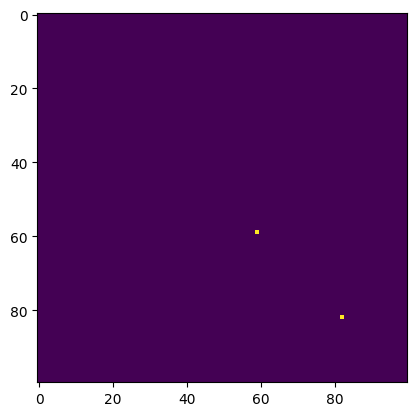

In [94]:
plt.imshow(adj_matrix[:100,:100])

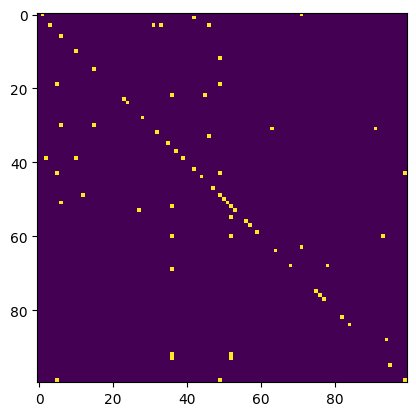

In [98]:
plt.imshow(adj_matrix_ot[:100,:100]>1e-5)

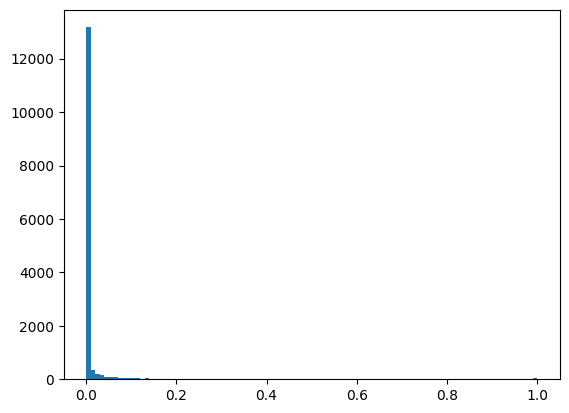

In [100]:
plt.hist(np.diag(adj_matrix_ot), bins=100);

In [101]:
np.diag(adj_matrix_ot).mean()

0.025362922

### Refinement (OML)

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
from IPython.core.display import HTML
from IPython.display import display

display(HTML("<style>.container { width:100% !important; }</style>"))


from pprint import pprint
from tqdm.auto import tqdm

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics
from oml.retrieval.postprocessors.pairwise import PairwiseEmbeddingsPostprocessor
from oml.samplers.category_balance import CategoryBalanceSampler
from oml.samplers.balance import BalanceSampler
from oml import const

from src.refinement import BioDatasetWithLabels, BioDatasetQueryGallery, SimpleSiamese, SimpleExtractor, PairsSamplerTwoModalities

In [107]:
import oml

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
# DATA

# I assume that descriptors of both types will have the same size after PCA
feat_dim_after_pca = config.N_LSI_COMPONENTS_GEX
hospital_encoder = LabelEncoder()
categories_ = hospital_encoder.fit_transform(sol_train.obs.batch[train_index])
categories = np.concatenate([categories_, categories_])
# index          0  1  2  3  4  5  6  7
#labels =        [0, 0, 1, 1, 2, 2, 3, 3]
labels = list(range(first_modality_train.shape[0]))*2
#categories =    [0, 0, 0, 0, 1, 1, 1, 1]  # this is a hospital id
categories_ = hospital_encoder.fit_transform(sol_train.obs.batch[train_index])
categories = np.concatenate([categories_, categories_])
#is_first_type = [1, 0, 1, 0, 1, 0, 1, 0]
is_first_type = np.concatenate([np.ones(first_modality_train.shape[0]),
                                np.zeros(first_modality_train.shape[0])])
#descriptors =   torch.randn((len(labels), feat_dim_after_pca))
descriptors = torch.cat([torch.Tensor(first_modality_train.values), torch.Tensor(gex_train.values)]).cuda()

labels2category = dict(zip(labels, categories))  # label to hospital id

In [110]:
from copy import deepcopy

In [115]:
#extractor1 = SimpleExtractor(in_dim=feat_dim_after_pca, out_dim=config.EMBEDDING_DIM)
#extractor2 = SimpleExtractor(in_dim=feat_dim_after_pca, out_dim=18)
extractor1 = deepcopy(model.encoder_modality1)
extractor2 = deepcopy(model.encoder_modality2)

siamese = SimpleSiamese(extractor1=extractor1, extractor2=extractor2).train().cuda()
optimizer = torch.optim.AdamW(siamese.parameters(), lr=1e-4)
miner = PairsSamplerTwoModalities(hard=False)  # it will not remember all the pairs since we overfit only on the hard ones
criterion = BCEWithLogitsLoss()

train_dataset = BioDatasetWithLabels(labels, categories, is_first_type, descriptors)
# batch_sampler = CategoryBalanceSampler(train_dataset.get_labels(), label2category=labels2category, n_labels=2, n_instances=2, n_categories=2)
batch_sampler = BalanceSampler(train_dataset.get_labels(), n_labels=4, n_instances=2)
train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)

In [116]:
#n_epochs = 50000
n_epochs = 5

for _ in tqdm(range(n_epochs), position=0):
    for batch in tqdm(train_loader, leave=False, position=1):
        features_a = batch[const.INPUT_TENSORS_KEY][batch["is_first_type"]]
        features_b = batch[const.INPUT_TENSORS_KEY][~batch["is_first_type"]]
        labels_a = batch[const.LABELS_KEY][batch["is_first_type"]]
        labels_b = batch[const.LABELS_KEY][~batch["is_first_type"]]
        
        ids1, ids2, is_negative_pair = miner.sample(features_a, features_b, labels_a, labels_b)
        probs = siamese(x1=features_a[ids1], x2=features_b[ids2])  # can think about it as distances
        loss = criterion(probs, is_negative_pair.float().cuda())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(loss.item())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15363 [00:37<?, ?it/s]

0.22143201529979706


  0%|          | 0/15363 [00:39<?, ?it/s]

0.2120780348777771


  0%|          | 0/15363 [00:37<?, ?it/s]

0.06477153301239014


  0%|          | 0/15363 [00:38<?, ?it/s]

0.044805463403463364


  0%|          | 0/15363 [00:38<?, ?it/s]

0.06961286067962646


In [ ]:
#torch.save(siamese.state_dict, 'siamese.pickle')

### Custom eval

In [117]:
siamese.eval();

In [118]:
postproc_matrix  = torch.zeros(test_distances_numpy.shape)

In [120]:
#looking for promising indices in the matching
ind_first, ind_gex = np.where((adj_matrix_ot>1e-4))

In [121]:
feat_first = torch.Tensor(first_modality_test.values).cuda()
feat_gex = torch.Tensor(gex_test.values).cuda()

In [122]:
index_dataset = torch.utils.data.TensorDataset(torch.LongTensor(ind_first), torch.LongTensor(ind_gex))

In [123]:
for ind1, ind2 in tqdm(torch.utils.data.DataLoader(index_dataset, batch_size=2048)):
    x1 = feat_first[ind1]
    x2 = feat_gex[ind2]
    ans = torch.sigmoid(siamese(x1, x2)).detach().cpu()
    postproc_matrix[ind1, ind2] = ans

  0%|          | 0/462 [00:00<?, ?it/s]

In [124]:
postproc_matrix = postproc_matrix.cpu().numpy()

In [125]:
postproc_matrix.sum(1)

array([3.302113 , 1.5618122, 8.769382 , ..., 0.9907185, 0.4494646,
       3.673589 ], dtype=float32)

In [126]:
postproc_matrix /= (postproc_matrix.sum(1, keepdims=True)+1e-12)

In [127]:
np.diag(postproc_matrix == postproc_matrix.max(1,keepdims=True)).mean()

0.011084561263772733

In [128]:
np.diag(adj_matrix_ot).mean()

0.025362922

In [129]:
# the metric actually decreases a little bit
np.diag(postproc_matrix).mean()

0.0122679975